### In this notebook, we introduce two basic methods to improve the speed and accuracy for DTW: the warping constraint and normalization.

#### As we mentioned in the end of the previous post, one of the most critized point for DTW is that it is slow. In this notes, we introduce the warping constraint $w$ and explain why it is important for DTW.

#### First, we define the warping constraint $w$ as the degree of deviation from the diagonal, which can be expressed as number of cells  or a ratio between the allowed deviation and the length of sequences, i.e., $w = {r \over n}$ as shown in the pictures below.



## Sakoe-Chiba Band
<img src="Sakoe-Chiba Band.png", style="width:400px">
#### Source: Abdullah Mueen, Eamonn J. Keogh: Extracting Optimal Performance from Dynamic Time Warping. KDD 2016: 2129-2130

### The importance of this warping constraint $w$ is two-fold: it is a straight forward way to speed up the algorithm and increase accuracy.

### Speed: 
### It is very intuitive to recognize that giving a warping constraint will speed up the DTW since it simply explores less cells than the original one (See figure above). The scanned cells reduce from $n^2$ to $rn$ (or $wn^2$). It is also very easy to see it from the highlighted code below as the second for loop runs only $2\times windows$ at most.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dtw_constraint(template, unknown, window = 10, alignment_curve = False, gen_plot = False):

    template = np.array(template)
    unknown = np.array(unknown)
    # local constraint
    window = max( window, abs(len(template)-len(unknown)) )
    # dtw matrix initialization
    dtw = np.ndarray(shape = (len(template), len(unknown)))
    dtw[:,:] = float('inf')

    for row in range(dtw.shape[0]):
        # set the constraint
        for col in range(max(0, row-window), min(len(unknown), row+window)):
            dist = np.sqrt( np.sum( (template[row] - unknown[col])**2 ) )
            if row == 0 and col == 0:
                dtw[row, col] = dist
            elif row == 0:
                dtw[row, col] = dist + dtw[row, col - 1]
            elif col == 0:
                dtw[row, col] = dist + dtw[row-1, col]
            else:
                dtw[row, col] = dist + min(dtw[row-1, col], dtw[row-1, col-1], dtw[row, col-1])
                idx = np.argsort( [ dtw[row-1, col], dtw[row-1, col-1], dtw[row, col-1] ]  )[0]

    # trace for alignment curve
    if alignment_curve:
        row = 0
        col = 0
        alignment = [ [row, col] ]

        while row != dtw.shape[0] - 1 or col != dtw.shape[1] - 1:
            if row == dtw.shape[0] - 1:
                col += 1
            elif col == dtw.shape[1] - 1:
                row += 1
            else:
                idx = np.argsort( [ dtw[row+1, col], dtw[row+1, col+1], dtw[row, col+1] ]  )[0]
                if idx == 0:
                    row += 1
                elif  idx == 1:
                    row += 1
                    col += 1
                else:
                    col += 1
            alignment.append([row, col])
        alignment = np.array(map(np.array, alignment))
    
    if gen_plot:
        fig = plt.figure(figsize = (7,7))
        plt.imshow( dtw )
        plt.xlim(0, dtw.shape[1])
        plt.ylim(0, dtw.shape[0])
        plt.title("Constrained Dynamic Time Warping Matrix Heat Map")
        if alignment_curve:
            plt.plot( alignment[:,1], alignment[:,0], linewidth = 3, color = 'white', label = 'alignment curve')
            plt.legend(loc = 'best')
        plt.show()


    if alignment_curve:
        return dtw, alignment
    else:
        return dtw

### Accuracy:



### First we generate two sets of sequences: the first one is a zero sequence of length 100 with a spike of unity somewhere between 0 and 29, and the second one is the ones with a spike of unity somewhere between 70 and 99.

### These are clearly a naive dataset with two different class, defined by the location of their spikes.

In [3]:
# generate two sets of sequences
np.random.seed(100)

a = {}
b = {}

for i in range(5):
    a["seq_%s" %i] = np.zeros(100)
    a["seq_%s" %i][np.random.choice(30,1)] = 1
    b["seq_%s" %i] = np.zeros(100)
    b["seq_%s" %i][np.random.choice(np.arange(70,100),1)] = 1

    # you can plot them if you want to
    if False:
        plt.plot(np.arange(100), a["seq_%s" %i], color = 'b')
        plt.plot(np.arange(100), b["seq_%s" %i], color = 'r')
        plt.show()

In [4]:
# import function from previous post
from dtw import *

### Now if we have a query series with length 100 and a spike somewhere between 0 and 29, we know it belongs to the class a. How about DTW?

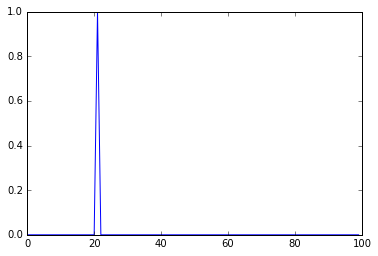

In [5]:
query = np.zeros(100)
query[np.random.choice(30,1)] = 1
plt.plot(np.arange(100), query)

### We first run the basic DTW algorithms, i.e., no constraints at all.

## Reminder: DTW is a measure of distances between two sequences, so a smaller DTW meausre indicates they are 'closer'.

In [6]:
basic_dis = []

for i in range(5):  
    basic_dis.append( dtw_basic(arr1 = a['seq_%s' %i], arr2 = query, alignment_curve = False, gen_plot = False)[-1,-1] )

for i in range(5):
    basic_dis.append( dtw_basic(arr1 = b['seq_%s' %i], arr2 = query, alignment_curve = False, gen_plot = False)[-1,-1] )

basic_dis

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Next we run the DTW algorithms with warping constraint.

In [7]:
constraint_dis = []

for i in range(5):   
    constraint_dis.append( dtw_constraint(template = a['seq_%s' %i], unknown = query, window = 20, 
                                          alignment_curve = False, gen_plot = False)[-1,-1] )
for i in range(5):
    constraint_dis.append( dtw_constraint(template = b['seq_%s' %i], unknown = query, window = 20, 
                                          alignment_curve = False, gen_plot = False)[-1,-1] )

constraint_dis

[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0]

### As you can see, DTW gives all zeros in the first case and gives half zeros (class a) and half twos (class b). 

### Let's take a look at the first case. It is actually what we expected if we did not know there are two classes since they both are a serious of zeros with a spike between 0 and 99. It is reasonable to categorize them into a class.

### As we designed these series as two classes, we know, however, they are DIFFERENT. It helps to introduce a warping constraint such that it won't connect points too far away.



### Next we visualize how these two sequence are connected in two different cases.


In [8]:
def dtw_plot(query, template, alignment_curve):
    
    fig = plt.figure(figsize = (14,7))
    # shift the query sequence up
    plt.plot(np.arange(len(query)), query + 2, lw = 2, label = 'query')
    plt.plot(np.arange(len(template)), template, lw = 2, label = 'template')
    plt.legend(loc = 'best')
    for x1, x2 in alignment_curve:
        #print query[x1]+2, a['seq_%s' %0][x2]
        plt.plot([x1,x2], [template[x1], query[x2]+2], 'r')
        

### Let's start with the case that both query and template are in the same class.

### Note: we have shift our query sequence by 2 units for visualization

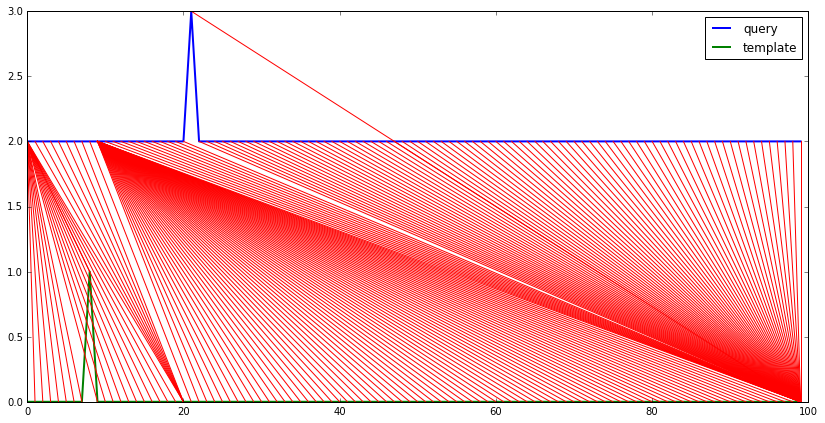

In [9]:
c, d = dtw_basic(arr1 = query, arr2 = a['seq_0'], alignment_curve = True, gen_plot = False)

dtw_plot(query, a['seq_0'], alignment_curve = d)

### Query and template are in the different class

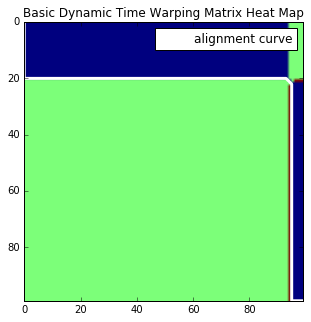

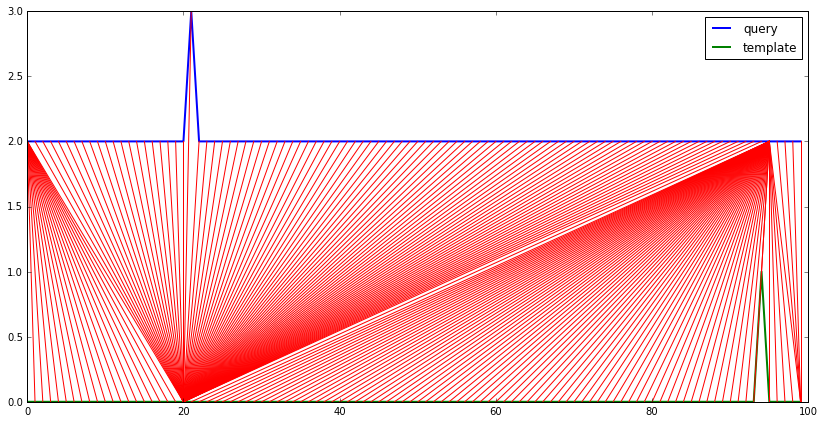

In [10]:
c, d = dtw_basic(arr1 = query, arr2 = b['seq_0'], alignment_curve = True, gen_plot = True)

dtw_plot(query, b['seq_0'], alignment_curve = d)

### Next, it looks much better if we introduce warping constraint

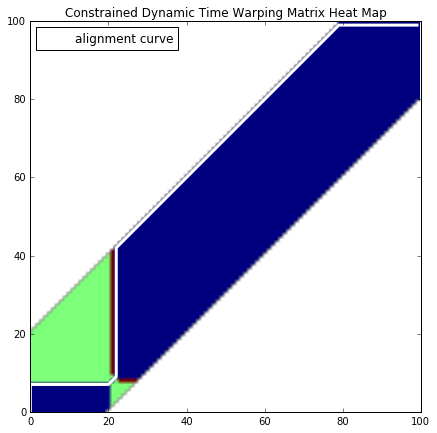

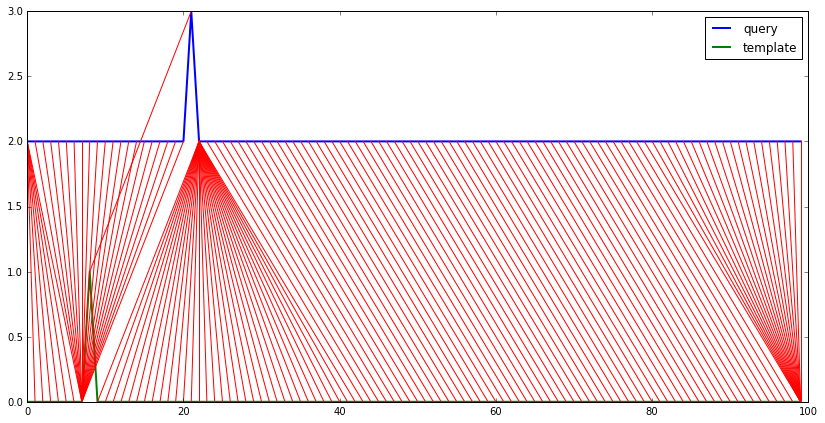

In [11]:
c, d = dtw_constraint(template = a['seq_0'], unknown = query, window = 20, 
                                          alignment_curve = True, gen_plot = True)
dtw_plot(query, a['seq_0'], alignment_curve = d)

### Query and template are in the different classes.

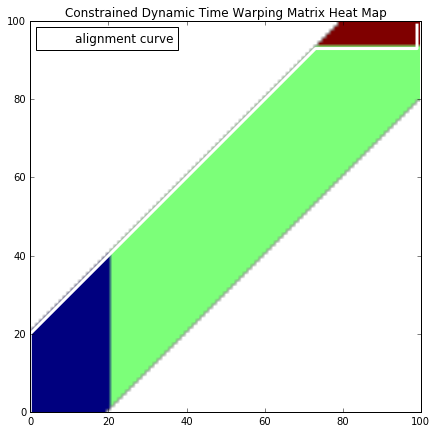

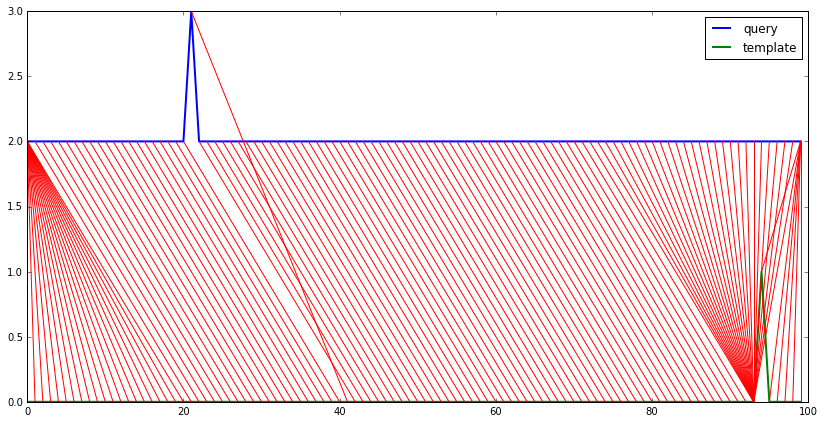

In [12]:
c, d = dtw_constraint(template = b['seq_0'], unknown = query, window = 20, 
                                          alignment_curve = True, gen_plot = True)
dtw_plot(query, b['seq_0'], alignment_curve = d)

## Z-normalization

### As we can observe from above examples, we can shift our sequences by an arbitrary constant without changing thier shapes. This shift, however, will change the DTW. So we need to normalize them.

### Here we use z-normalization which is given by:

$$ x_i^{\prime} = (x_i - \bar{x_i})/\sigma_i$$

### where $\bar{x_i}$ and $\sigma_i$ are the mean and the standard deviation of sequence i.


In [13]:
def z_normalize(array):
    
    return 1.0*(array - np.mean(array))/np.std(array)

### Let's take a look at how the normalization affects our results.

In [14]:
# shift the a sequence by 2 and compute the DTW
dtw_constraint(template = a['seq_0'], unknown = a['seq_0']+2, window = 20, 
                                          alignment_curve = False, gen_plot = False)[-1,-1]


200.0

In [15]:
# shift the a sequence by 2 and compute the DTW after normalization
dtw_constraint(template = z_normalize(a['seq_0']), 
               unknown = z_normalize(a['seq_0']+2), window = 20, 
               alignment_curve = False, gen_plot = False)[-1,-1]


2.1650736758971334e-13

### As shown above,  it is considered as two different sequences with a huge distance between them if we do not impose the z-normalization. But we can recognize they are very similar if normalized.


### We will impose the normalization condition hereafter since the similarity of the evolutions (if dealing with time series) between two sequences is what we really care about.

## DTW in action


### Next we try to apply the DTW on our financial time series data. Here we use the 'SPY' as our example.


### The objective is to find the most similar sequences in history and forecast the 'future' according to it. Here we shall notice that the assumption behind is: the price actions will evolve similarly even though they won't repeat exactly.

In [16]:
spy = pd.read_csv(os.getcwd() + "/SPY.csv", parse_dates = True, index_col = 0)
spy.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-22,243.570007,245.619995,243.550003,245.440002,245.440002,63140100
2017-08-23,244.330002,245.050003,244.160004,244.559998,244.559998,50203800
2017-08-24,245.000000,245.179993,243.750000,243.990005,243.990005,49730500
2017-08-25,244.899994,245.610001,244.389999,244.559998,244.559998,60191600
2017-08-28,245.169998,245.199997,244.089996,244.600006,244.600006,31125949


### Assume that we use a 60 days window as the length of query and template sequences.

In [17]:
# assign our query
query = spy.iloc[-60:]['Adj Close']

### We then divide our history into a set of templates.

In [18]:
# we slices a 60 days sequence every 20 steps
window = 60
step = 20
n = int( (len(spy) - window)/step )

# create a dataframe to store results 
dtw_df = pd.DataFrame(columns = ['start_date', 'end_date', 'dtw_basic', 'dtw_constraint'], index = [0])

for i in range(n):
    # template sequence
    template = spy.iloc[i*step:i*step + window]['Adj Close']
    # apply z-normalization
    a = z_normalize(array = query)
    b = z_normalize(array = template)
    
    dtw_df.loc[i, 'start_date'] = spy.index[i*step]
    dtw_df.loc[i, 'end_date'] = spy.index[i*step+window]
    dtw_df.loc[i, 'dtw_basic'] = dtw_basic(arr1 = b, arr2 = a, 
                                           alignment_curve = False, gen_plot = False)[-1,-1]
    dtw_df.loc[i, 'dtw_constraint'] = dtw_constraint(template = b, unknown = a, window = 5, 
                                                     alignment_curve = False, gen_plot = False)[-1,-1]
    

In [19]:
dtw_df.head()

,start_date,end_date,dtw_basic,dtw_constraint
0,2001-08-29 00:00:00,2001-11-29 00:00:00,39.5337,55.8196
1,2001-10-03 00:00:00,2001-12-28 00:00:00,25.0894,26.318
2,2001-10-31 00:00:00,2002-01-29 00:00:00,31.3126,39.6614
3,2001-11-29 00:00:00,2002-02-27 00:00:00,43.6612,77.4653
4,2001-12-28 00:00:00,2002-03-27 00:00:00,35.8443,58.0295


In [20]:
# find out the period with shortest dtw measurements

print dtw_df.sort_values(by = 'dtw_basic').iloc[0]
print dtw_df.sort_values(by = 'dtw_constraint').iloc[0]

start_date        2005-05-31 00:00:00
end_date          2005-08-24 00:00:00
dtw_basic                     18.5722
dtw_constraint                18.7026
Name: 47, dtype: object
start_date        2005-05-31 00:00:00
end_date          2005-08-24 00:00:00
dtw_basic                     18.5722
dtw_constraint                18.7026
Name: 47, dtype: object


### Once we find the most similar sequences, we can 'forecast' the possible trends towards future.

In [21]:
start_idx = spy.index.get_loc( dtw_df.sort_values(by = 'dtw_basic').iloc[0]['start_date'] )
end_idx = spy.index.get_loc( dtw_df.sort_values(by = 'dtw_basic').iloc[0]['end_date'] )

# we make our forecast for 20 days forward
# notice that we align our starting points to unity
forecast = spy.iloc[start_idx: end_idx + 20]['Adj Close']/spy.iloc[start_idx]['Adj Close']
query = spy.iloc[-60:]['Adj Close']/spy.iloc[-60]['Adj Close']

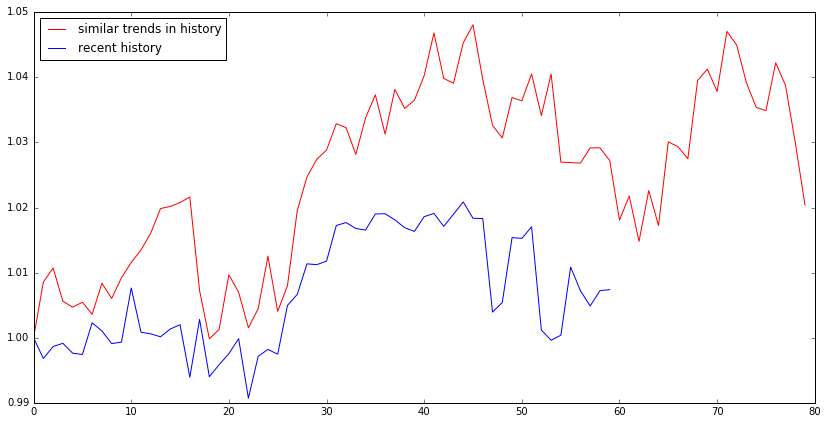

In [22]:
fig = plt.figure(figsize = (14,7))
plt.plot(np.arange(len(forecast)), forecast, "-r", label = 'similar trends in history')
plt.plot(np.arange(len(query)), query, "-b", label = 'recent history')
plt.legend(loc = 'best')
plt.show()

References:


[1] Abdullah Mueen, Eamonn J. Keogh: Extracting Optimal Performance from Dynamic Time Warping. KDD 2016: 2129-2130